In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tempfile
from matplotlib import pyplot as plt

from sklearn import metrics

batch_size = 32
img_height = 300
img_width = 300
data_dir = r"dataset" # Dataset directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3817 files belonging to 3 classes.
Using 3054 files for training.
Found 3817 files belonging to 3 classes.
Using 763 files for validation.


In [2]:
class_names = train_ds.class_names
print(class_names)

['brown_spot', 'normal', 'tungro']


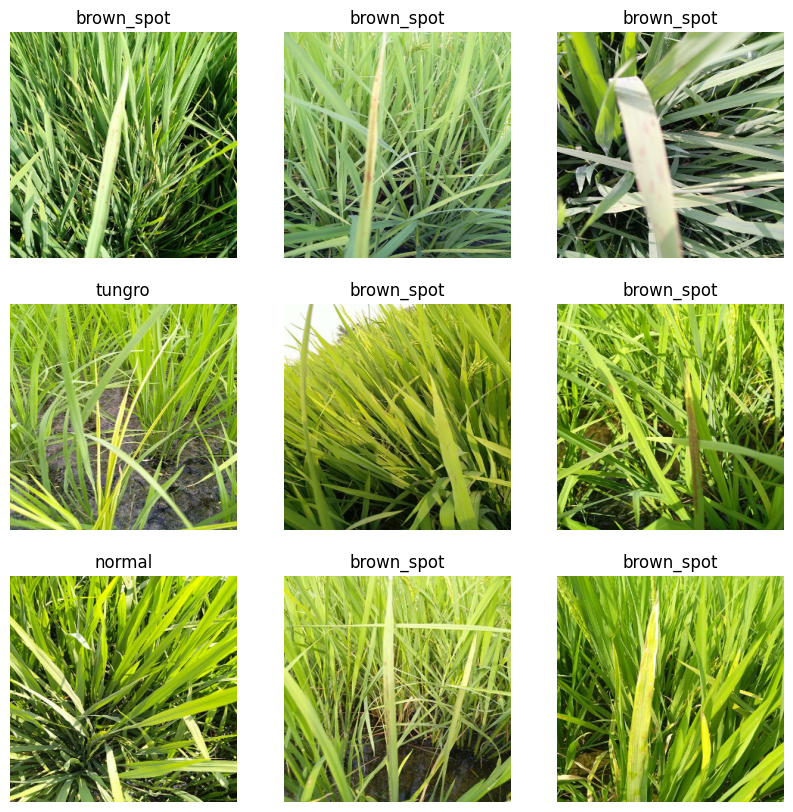

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
# Change number of classes according to your dataset
num_classes = 3 

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [9]:
import os
epochs=15
model.fit(train_ds,validation_data=val_ds,epochs=epochs)


#Save the entire model as a SavedModel.
if not os.path.exists('saved_model'):
    os.mkdir('saved_model')
model.save('saved_model/my_model')

Epoch 1/15
96/96 [==============================] - 252s 3s/step - loss: 0.9562 - accuracy: 0.5760 - val_loss: 0.7335 - val_accuracy: 0.6920
Epoch 2/15
96/96 [==============================] - 249s 3s/step - loss: 0.6056 - accuracy: 0.7597 - val_loss: 0.5551 - val_accuracy: 0.7811
Epoch 3/15
96/96 [==============================] - 257s 3s/step - loss: 0.4039 - accuracy: 0.8487 - val_loss: 0.4991 - val_accuracy: 0.8283
Epoch 4/15
96/96 [==============================] - 251s 3s/step - loss: 0.2498 - accuracy: 0.9057 - val_loss: 0.5916 - val_accuracy: 0.7982
Epoch 5/15
96/96 [==============================] - 249s 3s/step - loss: 0.1196 - accuracy: 0.9594 - val_loss: 0.6380 - val_accuracy: 0.8519
Epoch 6/15
96/96 [==============================] - 247s 3s/step - loss: 0.0514 - accuracy: 0.9866 - val_loss: 0.5366 - val_accuracy: 0.8624
Epoch 7/15
96/96 [==============================] - 246s 3s/step - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.5463 - val_accuracy: 0.8781
Epoch 8/15
96

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [10]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

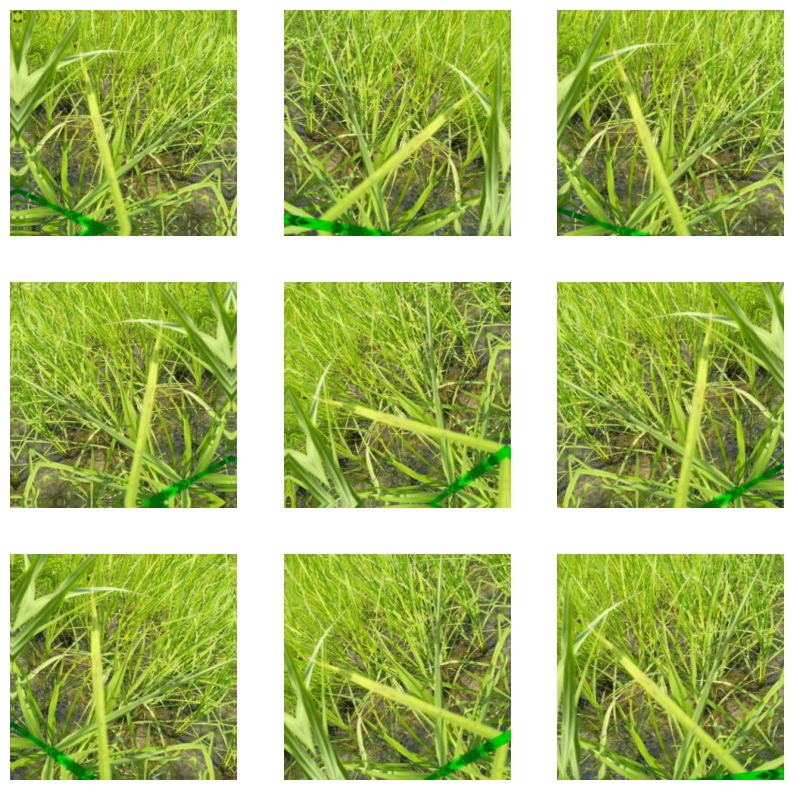

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [13]:
img = keras.preprocessing.image.load_img(
    "Cochliobolus_miyabeanus.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to brown_spot with a 100.00 percent confidence.
